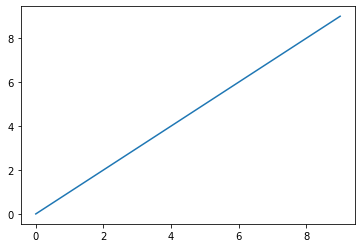

In [1]:
import shutil, os
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(10))

In [2]:
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from inference import *
from detectron2.utils.visualizer import Visualizer
import cv2
from PIL import Image

try:
    DatasetCatalog.register("rpd_valid", grab_valid)
except:
    print('Already registered.')
    #do nothing
try:
    DatasetCatalog.register("rpd_train", grab_train)
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_valid").thing_classes = ["rpd"]
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_train").thing_classes = ["rpd"]   
except:
    print('Already registered.')
    #do nothing

In [17]:
#predict
cfg = get_cfg()
cfg.merge_from_file('configs/working')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output/model_0005999.pth",
                     "MODEL.ROI_HEADS.NMS_THRESH_TEST",".05",
                     "MODEL.ROI_HEADS.SCORE_THRESH_TEST",".001"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.05
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output/model_0005999.pth


In [18]:
#build model
from detectron2.modeling import build_model
model = build_model(cfg)  # returns a torch.nn.Module
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
model.eval(); #set model in evaluation mode

In [19]:
from detectron2.data import build_detection_test_loader
myloader = build_detection_test_loader(cfg,"rpd_valid")

In [20]:
from detectron2.evaluation import COCOEvaluator
myeval = COCOEvaluator("rpd_valid",tasks={'bbox'},output_dir = 'output/results')

In [21]:
from detectron2.evaluation import inference_on_dataset
eval_result = inference_on_dataset(model,myloader,myeval)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

In [22]:
cocoDt = myeval._coco_api.loadRes(os.path.join(myeval._output_dir,'coco_instances_results.json'))


Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!


In [9]:
MetadataCatalog.get('rpd_valid').json_file

'output/results/rpd_valid_coco_format.json'

In [23]:
from pycocotools.cocoeval import COCOeval
mycoco = COCOeval(myeval._coco_api,cocoDt,iouType ='bbox')

In [38]:
mycoco.params.iouThrs = [.5]
#mycoco.params.recThrs = [0,.5,.75,1]
mycoco.params.maxDets = [100]
#mycoco.params.imgIds=[inputs[0]['image_id']]
mycoco.params.areaRng = [[0, 10000000000.0]]

mycoco.evaluate()
mycoco.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.01s).


(1, 101, 1, 1, 1)
Scores: [0.99428046 0.98351711 0.98039883 0.97660565 0.97300673 0.96998292
 0.9667927  0.96431422 0.96240115 0.96099854 0.95853853 0.9575175
 0.95541656 0.95414305 0.95323306 0.94862849 0.94592482 0.9422437
 0.94010872 0.93661302 0.93368036 0.9324196  0.92929298 0.92590088
 0.92115188 0.91976649 0.91784948 0.91241276 0.90822506 0.90396512
 0.90171599 0.89461201 0.89358473 0.8915292  0.88854766 0.88479257
 0.88028067 0.87609994 0.86422771 0.85873044 0.85659522 0.85186601
 0.84591836 0.83769321 0.83211875 0.82645708 0.81513333 0.80620056
 0.79759824 0.78585428 0.76889253 0.75612706 0.74512869 0.72883612
 0.71566457 0.7064085  0.69410384 0.68017137 0.65331948 0.62868387
 0.60727888 0.57597512 0.53323209 0.52209258 0.49665236 0.44250563
 0.37693155 0.32824379 0.29237685 0.24325396 0.20077929 0.11136428
 0.07070699 0.04868686 0.01601601 0.00662579 0.00334433 0.00168154
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0

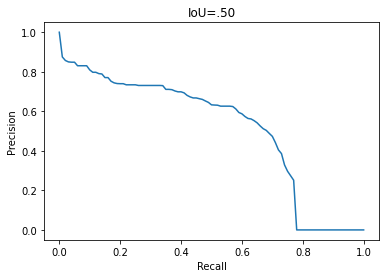

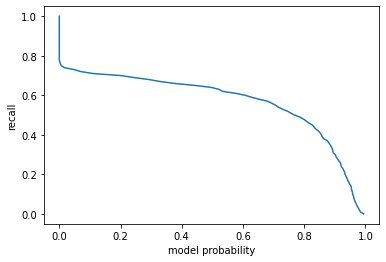

In [39]:
print(mycoco.eval['precision'].shape) #[T,R,K,A,M] parameter dims
# "imgIds": [all] N img ids to use for evaluation 
# "catIds": [all] K cat ids to use for evaluation 
# "iouThrs": [.5:.05:.95] T=10 IoU thresholds for evaluation #this many PR curves to average over
# "recThrs": [0:.01:1] R=101 recall thresholds for evaluation #count precision at these points on curve
# "areaRng": [all,small,medium,large] A=4 area ranges for evaluation 
# "maxDets": [1 10 100] M=3 thresholds on max detections per image
pr = mycoco.eval['precision'][0, #iouthresh
                         :, #recall level
                         0, #catagory
                         0, #area range
                         0] #max detections per image
rc = mycoco.params.recThrs
plt.plot(rc,pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('IoU=.50')

scores = mycoco.eval['scores'][0,:,0,0,0]
print('Scores:',scores)
print('Number of images:',len(mycoco.params.imgIds))
plt.figure()
plt.plot(scores,rc)
plt.xlabel('model probability')
plt.ylabel('recall')
print(rc)

Text(0, 0.5, 'FP scan rate')

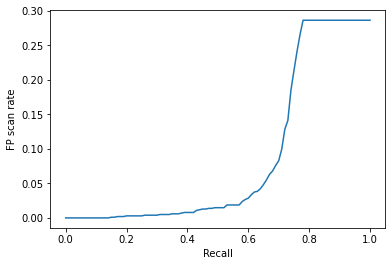

In [92]:
#FP rate, 1 RPD in image = FP
fpr = []
for s in scores:
    ng = 0
    fp = 0
    for el in mycoco.evalImgs:
        if el is None:
            ng=ng+1
        elif len(el['gtIds'])==0:
            ng=ng+1
            if (np.array(el['dtScores']) >s).sum() > 0:
                fp=fp+1
        else:
            continue
    fpr.append(fp/ng)
plt.plot(rc,fpr)
plt.xlabel('Recall')
plt.ylabel('FP scan rate')

In [91]:
print(ng)
print(fp)

1013
42


1

In [5]:
pred = DefaultPredictor(cfg)
outputs = pred(im)["instances"].to("cpu")
th = 0.1
filtered = outputs[outputs.scores > th]

/root/miniconda3/envs/detectron/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


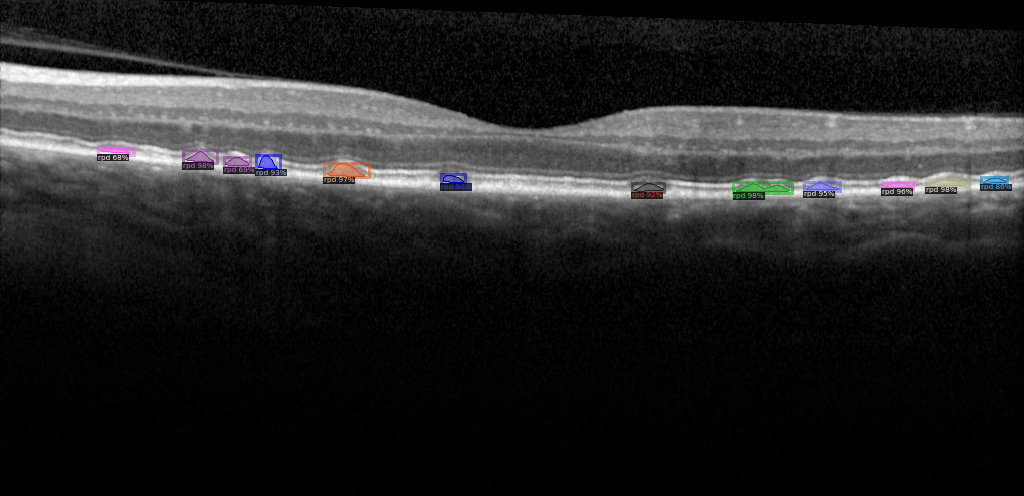

In [37]:
v2 = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
v2._default_font_size = 12
result_model = v2.draw_instance_predictions(filtered).get_image()
img_model = Image.fromarray(result_model)
img_model